In [26]:
from graphdatascience import GraphDataScience

# Configures the driver with AuraDS-recommended settings
gds = GraphDataScience(
    "neo4j+ssc://35.181.44.209:7687",
    auth=("neo4j", "neo4jdss")
)

print(gds.version())

2.0.2


In [27]:
# Sets database (if not default one)
gds.set_database("wine")

In [8]:
# Create a minimal similarity graph
gds.run_cypher(
  """
  WITH 'Trimbach, Pinot Gris Hommage Jeanne' AS wine1, 'Schieferkopf, Sylvaner' AS wine2, 'Hugel, Cuvee des Eveques Riesling' AS wine3, 'Hugel, Tokay Pinot Gris Jubilee' AS wine4, 'Nicolas' AS person1, 'Pierre' AS person2, 'Eva' AS person3, 'Romain' AS person4
  MATCH (w1:Wine) WHERE w1.DISPLAY_NAME = wine1
  MATCH (w2:Wine) WHERE w2.DISPLAY_NAME = wine2
  MATCH (w3:Wine) WHERE w3.DISPLAY_NAME = wine3
  MATCH (w4:Wine) WHERE w4.DISPLAY_NAME = wine4
  MERGE (p1:Person {name: person1})
  MERGE (p2:Person {name: person2})
  MERGE (p3:Person {name: person3})
  MERGE (p4:Person {name: person4})
  MERGE (p1)-[:LIKES]->(w1)
  MERGE (p1)-[:LIKES]->(w2)
  MERGE (p2)-[:LIKES]->(w2)
  MERGE (p2)-[:LIKES]->(w3)
  MERGE (p3)-[:LIKES]->(w1)
  MERGE (p3)-[:LIKES]->(w2)
  MERGE (p4)-[:LIKES]->(w3)
  MERGE (p4)-[:LIKES]->(w4)
  """
)

""


In [9]:
# Project the graph into the GDS Graph Catalog
# We call the object representing the projected graph `G_wines`
G_wines, res = gds.graph.project("neo4j-wines", ["Person", "Wine"], "LIKES")

In [11]:
n = G_wines.node_count()

In [12]:
n

125218

In [15]:
similarity_res = gds.nodeSimilarity.write(
    G_wines,                          #  Graph object
    writeRelationshipType="SIMILAR",  #  Configuration parameters
    writeProperty="score"
)

In [16]:
similarity_res

preProcessingMillis                                                       0
computeMillis                                                            55
writeMillis                                                              47
postProcessingMillis                                                     -1
nodesCompared                                                             4
relationshipsWritten                                                      8
similarityDistribution    {'p1': 0.3333320617675781, 'max': 1.0000057220...
configuration             {'topK': 10, 'writeConcurrency': 4, 'similarit...
Name: 0, dtype: object

In [30]:
import pandas
import matplotlib.pyplot as plt

In [28]:
# get similarity matrix data frame from graph
# Create a minimal similarity graph
pd = gds.run_cypher(
  """
  MATCH (p1:Person)
  MATCH (p2:Person)
  OPTIONAL MATCH (p1)-[s:SIMILAR]->(p2)
  RETURN p1.name AS person1, p2.name AS person2, coalesce(s.score, 0) AS score
  """
)

In [29]:
pd

,person1,person2,score
0,Nicolas,Nicolas,0.000000
1,Nicolas,Pierre,0.333333
2,Nicolas,Eva,1.000000
3,Nicolas,Romain,0.000000
4,Pierre,Nicolas,0.333333
5,Pierre,Pierre,0.000000
6,Pierre,Eva,0.333333
7,Pierre,Romain,0.333333
8,Eva,Nicolas,1.000000
9,Eva,Pierre,0.333333


In [34]:
pd.style.background_gradient(cmap ='RdYlBu')\
        .set_properties(**{'font-size': '14px'})

,person1,person2,score
0,Nicolas,Nicolas,0.000000
1,Nicolas,Pierre,0.333333
2,Nicolas,Eva,1.000000
3,Nicolas,Romain,0.000000
4,Pierre,Nicolas,0.333333
5,Pierre,Pierre,0.000000
6,Pierre,Eva,0.333333
7,Pierre,Romain,0.333333
8,Eva,Nicolas,1.000000
9,Eva,Pierre,0.333333


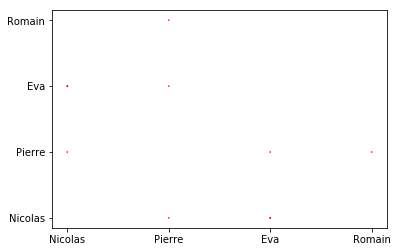

In [36]:
plt.scatter(pd['person1'], pd['person2'], pd['score'],color='red')